<a href="https://colab.research.google.com/github/mahossam/cell_type_classification_scrna_seq/blob/main/Cell_Type_Classification_using_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Cell Annotation with Single Cell RNA-seq




## Introduction

Single-cell RNA-seq data are designed to measure the activity (or expression) of a set of genes within a single cell at a specific point in time. The resulting data is a high-dimensional vector of integer values, where each dimension represents the expression level of a particular gene, measured by the number of corresponding RNA molecules found in the cell.

Here we train two baseline classifiers and a self-attention transformer to classify cells by their cell type using single-cell RNA-seq data.

The Self-Attention Transformer is a proof of concept that beats the Random Forest baseline but did not beat the Logistic Regression one. The Self-Attention module is implemented from scratch.

## Install dependencies

In [ ]:
!pip install scanpy
!pip install gdown
!pip install leidenalg
!pip install scikit-misc
!pip install -U scvi-tools
!pip install einops

## Imports

In [ ]:
import numpy as np
import os
import scanpy as sc
import anndata
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

## Download data (data source is removed from this notebook for confdentiality reasons)



In [ ]:
# Download the data
# Check if file exists and is not empty
if not os.path.exists('sc_data.npy') or os.path.getsize('sc_data.npy') == 0:
    raise Exception("File not downloaded successfully")

# Read Data

In [ ]:
cell_file = "sc_data.npy"

cells = np.load(cell_file, allow_pickle=True).ravel()[0]

expressions = cells["UMI"].toarray()  # sparse matrix of gene expressions
gene_names = cells["gene_ids"]  # gene names
cell_classes = cells["classes"]  # cell classes

In [ ]:
# Print the shape of expressions
print("Shape of expressions:", expressions.shape)

# Print the first few rows of expressions
print("\nFirst few rows of expressions:")
print(expressions[:5, :])

# Print the shape of gene_names and cell_classes
print("\nShape of gene_names:", gene_names.shape)
print("Shape of cell_classes:", cell_classes.shape)

In [ ]:
# Print the number of unique cell classes
print("Number of unique cell classes:", len(np.unique(cell_classes)))

# Print the first few cell classes
print("\nAll unique classes:")
print(np.unique(cell_classes))

Number of unique cell classes: 11

All unique classes:
['CD14+ Monocyte' 'CD19+ B' 'CD34+' 'CD4+ T Helper2' 'CD4+/CD25 T Reg'
 'CD4+/CD45RA+/CD25- Naive T' 'CD4+/CD45RO+ Memory' 'CD56+ NK'
 'CD8+ Cytotoxic T' 'CD8+/CD45RA+ Naive Cytotoxic' 'Dendritic']


# Pre-processing

### Remove doublets and save the results
To save execution time, no need to run this section unless the online pre-processed file doublet_removed.h5ad.gz is not accessible. If so, please un-comment the code and run.

In [ ]:
adata = anndata.AnnData(X=expressions, obs={'cell_type': cell_classes}, var={'gene_id': gene_names})
# Find and remove the doublets
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
adata

In [ ]:
import scvi
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df['dif'] = df.doublet - df.singlet
df.groupby('prediction').count()
doublets = df[df.prediction == 'doublet']

adata = anndata.AnnData(X=expressions, obs={'cell_type': cell_classes}, var={'gene_id': gene_names})

adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata = adata[~adata.obs.doublet]

sc.pp.filter_cells(adata, min_genes=200) # Remove cells with fewer than 200 genes

# Keep genes that are in cells above certain number
sc.pp.filter_genes(adata, min_cells = 10)

adata.X.sum(axis = 1)

adata.X = csr_matrix(adata.X)
adata.X
adata

adata.write_h5ad("doublet_removed.h5ad")

## Load data after has doublets removed (data source is removed from this notebook for confdentiality reasons)

In [ ]:
if not os.path.exists('doublet_removed.h5ad.gz') or os.path.getsize('doublet_removed.h5ad.gz') == 0:
    raise Exception("File not downloaded successfully")
!gzip -d doublet_removed.h5ad.gz
adata = sc.read_h5ad("doublet_removed.h5ad")

In [ ]:
# Make a copy of the counts in a new object. This will be used later in the deep learning model.
adata_original = adata.copy()
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 sum

In [ ]:
sc.pp.log1p(adata) # change to log counts

In [ ]:
adata.X.sum(axis = 1)

In [ ]:
# Similar to scGPT, find the 1200 highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 1200)
sc.pl.highly_variable_genes(adata)

In [ ]:
highly_variable_genes = adata.var.highly_variable.copy()
adata = adata[:, highly_variable_genes]

# Select the highly variable genes from the original counts.
# This will later be used for the deep learning model.
adata_original = adata_original[:, highly_variable_genes]

adata

# Models

## Data splitting

In [ ]:
# Fix the random seeds
import random
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the 'cell_type' column to get numerical labels
categorical_labels = label_encoder.fit_transform(adata.obs['cell_type'])

adata.obs['cell_type_encoded'] = categorical_labels
adata_original.obs['cell_type_encoded'] = categorical_labels

# Print the new column and the mapping
print("Mapping of text cell types to encoded labels:")
for text_label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{text_label}: {encoded_label}")


In [ ]:
# Split the data into train and test with percentages (80 and 20%)
from sklearn.model_selection import train_test_split
adata_train, adata_test = train_test_split(adata, test_size=0.2, stratify=adata.obs['cell_type_encoded'], random_state=42)

print(len(adata_train), len(adata_test))

# Prepare data for non-deep learning classifiers
X_train = adata_train.X.toarray()
y_train = adata_train.obs['cell_type_encoded'].to_numpy()
X_test = adata_test.X.toarray()
y_test = adata_test.obs['cell_type_encoded'].to_numpy()

## Baselines (non-deep learning models)

Baseline model metrics:

| Model                    | F1 (macro) | Accuracy |
|--------------------------|------------|----------|
| Random Forest            | %58       | %74      |
| Logistic Regression        | **%68**    | **%75**  |


Please refer the output below for all other performance metrics (Precision, Recall, Accuracy, and Balanced Accuracy)

Also refer to the last **Evaluation** cell in the notebook for compariso with the deep learning model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, classification_report, accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score
import pandas as pd

# Define the parameter grid for GridSearchCV
# Non-optimal parameters are commented to save execution time

rf_param_grid = {
    'n_estimators': [100], # [100, 200]
    'max_depth': [None], # [None, 10, 20],
    'min_samples_split': [2], #, 5],
    'min_samples_leaf': [1] #, 2]
}

lr_param_grid = {
    'C': [0.1], # 1, 10],
    'penalty': ['l2'],
    'max_iter': [100, 300],
}

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
lr_clf = LogisticRegression(random_state=42, class_weight='balanced')

grid_list= [rf_param_grid, lr_param_grid]
clf_list = [rf_clf, lr_clf]

for clf, param_grid in zip(clf_list, grid_list):
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring=make_scorer(f1_score), n_jobs=-1, refit=True)

    grid_search.fit(X_train, y_train)

    print(f"Best hyperparameters found by GridSearchCV for {clf}:")
    print(grid_search.best_params_)

    best_clf = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_clf.predict(X_test)

    print(f"\nClassification Report on Test Set for {clf}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0.0))

    print(f"Accuracy on Test Set:{accuracy_score(y_test, y_pred):.3f}")
    print(f"Balanced Accuracy on Test Set:{balanced_accuracy_score(y_test, y_pred):.3f}")

    if clf == lr_clf:
        conf_mat_lr = confusion_matrix(y_test, y_pred, normalize='true')
        conf_mat_pd_lr = pd.DataFrame(conf_mat_lr, columns=label_encoder.classes_, index=label_encoder.classes_)
        plt.figure(figsize=(10, 10))  # Adjust size as needed


In [ ]:
# @title
# print the number of paramters for the logistic regression
# print(best_clf.coef_.shape)

# plot the confusion matrix for the logistic regression classifier
plt.figure(figsize=(10, 10))  # Adjust size as needed
sns.heatmap(conf_mat_pd_lr, annot=True, fmt=".2f", cmap="plasma", cbar=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for the Logistic Regression")
plt.xticks(rotation=60, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

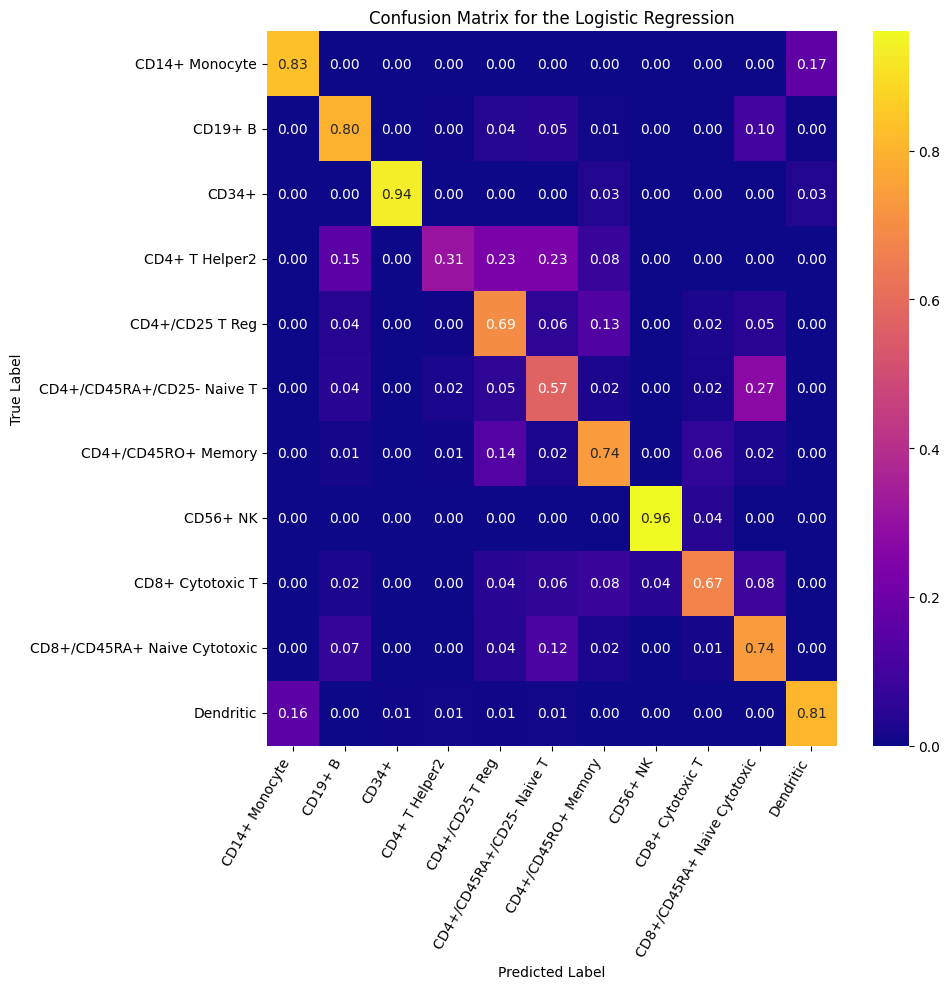

## Self-Attention Transformer

The model is inspired by scGPT use of genes and expression values to learn attention weights and representations of the cells:
https://www.biorxiv.org/content/10.1101/2023.04.30.538439v2

**Results**:
| Model                    | F1 (macro) | Accuracy |
|--------------------------|------------|----------|
| Random Forest            | 58%       | 74% *     |
| Self-Attenion Transformer | 62% *      | 62%      | 
| Logistic Regression        | **68%**    | **75%**  |

(*) Second best

#### Data splitting

In [ ]:
# @title
# Split the original counts data to 70 train, 10 validation, and 20 % test

from sklearn.model_selection import train_test_split
adata_original_train_val, adata_original_test = train_test_split(adata_original, test_size=0.2, stratify=adata_original.obs['cell_type_encoded'], random_state=42)

adata_original_train, adata_original_val = train_test_split(adata_original_train_val, test_size=0.125, stratify=adata_original_train_val.obs['cell_type_encoded'], random_state=42)

print(adata_original_train.shape)
print(adata_original_val.shape)
print(adata_original_test.shape)

X_train_nn = adata_original_train.X.toarray()
y_train_nn = adata_original_train.obs['cell_type_encoded'].to_numpy()
X_val_nn = adata_original_val.X.toarray()
y_val_nn = adata_original_val.obs['cell_type_encoded'].to_numpy()
X_test_nn = adata_original_test.X.toarray()
y_test_nn = adata_original_test.obs['cell_type_encoded'].to_numpy()

#### Bin the gene expression values similar to scGPT


In [ ]:
class ExpressionBinner:
    """
    Bins expression values per cell:
    - Bin edges are computed using only non-zero values.
    - Zeros are always assigned to bin 0.
    - Non-zero values are assigned to bins 1 to B+1.
    """
    def __init__(self, n_bins: int = 32):
        self.n_bins = n_bins

    def bin_cell(self, expr_vector):
        expr_vector = np.array(expr_vector)
        non_zero = expr_vector[expr_vector > 0]

        if len(non_zero) == 0:
            return np.zeros_like(expr_vector, dtype=int)

        bin_edges = np.linspace(np.min(non_zero), np.max(non_zero), self.n_bins + 1)
        bin_edges = np.unique(bin_edges)  # remove duplicate edges

        # Ensure more than two unique bins exist
        if len(bin_edges) <= 2:
            return (expr_vector > 0).astype(int)

        # Digitize non-zero values; result will be in 1..B+1
        binned = np.digitize(expr_vector, bins=bin_edges, right=False)
        binned[expr_vector == 0] = 0  # set zeros explicitly to bin 0
        return binned

    def bin_batch(self, X):
        return np.vstack([self.bin_cell(cell) for cell in X])


### The classification model
Similar to scGPT, **CellTypeClassifier** is a transformer-based model that takes the gene ids and the binnned expression interval ids as inputs. I ignored other types of inputs for simplicity.

No attention or pad masks were used since all the gene ids are given and the number of genes is fixed to 1200 highly variable genes.

Unlike scGPT, the model is trained directly to predict the cell type classes.

The model consists of:
- An embedding layer,
- four transformer layers (to save computation time),
- and a linear layer to output class logits.

Results:
| Model                    | F1 (macro) | Accuracy |
|--------------------------|------------|----------|
| Random Forest            | 58%       | 74% *     |
| Self-Attenion Transformer | 62% *      | 62%      | 
| Logistic Regression        | **68%**    | **75%**  |

(*) Second best

Please refer the output of the **Evaluation** cell at the end of the notebook for all other performance metrics (Precision, Recall, Accuracy, and Balanced accuracy)


In [ ]:
# The transfomer block and self attention implementations below are adapted
# from my previous implementations and from PyTorch's TransformerEncoderLayer
# and MultiheadAttention classes and multi_head_attention_forward() function.

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader


from torch.nn.init import constant_, xavier_uniform_
import torch.nn.functional as F
from einops import rearrange
from torch import Tensor

class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float=0.1, bias: bool = True) -> None:
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.bias = bias

        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.scale = 1 / (d_model // n_heads) ** 0.5

        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)

        self.out_proj = nn.Linear(d_model, d_model, bias=bias)

        self.dropout_layer = nn.Dropout(dropout)

        self.reset_parameters()

    def reset_parameters(self):
        for proj in [self.q_proj, self.k_proj, self.v_proj]:
            xavier_uniform_(proj.weight)
            if proj.bias is not None:
                constant_(proj.bias, 0.)

        if self.out_proj.bias is not None:
            constant_(self.out_proj.bias, 0.)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, attn_mask: Tensor | None = None) -> Tensor:
        """
        Args:
            query: (batch, seq_len, d_model)
            key: (batch, seq_len, d_model)
            value: (batch, seq_len, d_model)
            attn_mask: (seq_len, seql_len) or (batch * num_head, seq_len, seq_len): For information about the attention mask shapes, please refer to PyTorch's MultiheadAttention class and multi_head_attention_forward() function.
        Returns:
            Attention outputs (batch, seq_len, d_model)
        """
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)

        if attn_mask is not None:
            ndim = attn_mask.ndim
            assert ndim in [2, 3], "attn_mask must be 2D or 3D"
            if ndim == 2:
                attn_mask = attn_mask.unsqueeze(0)
                attn_mask = attn_mask.unsqueeze(0)
            elif ndim == 3:
                attn_mask = rearrange(attn_mask, "(b h) n n -> b h n n", h=self.n_heads)

        # Note: the attention mask functionality was not tested since I did not
        # use it in the classification model.

        q = rearrange(q, "b n (h q) -> b h n q", h=self.n_heads)
        k = rearrange(k, "b n (h q) -> b h n q", h=self.n_heads)
        v = rearrange(v, "b n (h q) -> b h n q", h=self.n_heads)

        q *= self.scale

        logits = q @ k.transpose(-2, -1)

        if attn_mask is not None:
            logits = logits + attn_mask

        attn_output_weights = F.softmax(logits, dim=-1)
        attn_output_weights = self.dropout_layer(attn_output_weights)

        attn_output = attn_output_weights @ v

        attn_output = rearrange(attn_output, "b h n d -> b n (h d)")

        attn_output = self.out_proj(attn_output)

        return attn_output

class TransformerBlock(nn.Module):
    def __init__(self, d_model: int = 128, n_heads: int = 4, dropout: float = 0.1):
        super().__init__()
        self.mha = MultiHeadedAttention(d_model = d_model, n_heads = n_heads, dropout = dropout)
        self.linear1 = nn.Linear(d_model, 4 * d_model)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(4 * d_model, d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x: Tensor, attn_mask: Tensor | None = None) -> Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
            attn_mask: For information about the allowed sizes, please refer to MultiheadAttention class above

        Returns:
            Transformer block output (batch, seq_len, d_model)
        """
        attn_output = self.mha(x, x, x, attn_mask=attn_mask)
        x = self.layer_norm1(x + self.dropout1(attn_output))
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = self.layer_norm2(x + self.dropout2(ff_output))

        # print("TF block x.shape:", x.shape)
        return x


# Implement the classifier using the manual transformer implementation
class CellTypeClassifier(nn.Module):
    def __init__(self, n_genes, n_bins, d_model, n_classes, n_layers=4, n_heads=4, dropout=0.5):
        super().__init__()
        self.gene_embedding = nn.Embedding(n_genes, d_model)
        self.bin_embedding = nn.Embedding(n_bins + 2, d_model)

        self.encoder_layers = nn.ModuleList([
            TransformerBlock(d_model=d_model, n_heads=n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])

        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, gene_ids, bin_ids):
        gene_emb = self.gene_embedding(gene_ids)
        bin_emb = self.bin_embedding(bin_ids)
        x = gene_emb + bin_emb  # (batch, seq_len, d_model)

        for layer in self.encoder_layers:
            x = layer(x)  # (batch, seq_len, d_model)

        x = x.mean(dim=1)        # Take the mean over all input tokens

        return self.classifier(x)  # (batch, n_classes)

#### Data formatting and preparation

In [ ]:
# Fix random seeds
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True

N_BINS = 14  # The number of expression intervals
batch_size = 32

# Prepare gene tokens input
gene_names = adata.var['gene_id'].tolist()
gene_to_id = {gene: idx for idx, gene in enumerate(gene_names)}
gene_ids = np.array([gene_to_id[gene] for gene in gene_names])

# Perform the binning of the expression values
binner = ExpressionBinner(n_bins=N_BINS)
X_train_binned = binner.bin_batch(X_train_nn)
X_val_binned = binner.bin_batch(X_val_nn)
X_test_binned = binner.bin_batch(X_test_nn)

#print min, max, avg stats for X arrays
print("X_train_binned min, max, avg:", np.min(X_train_binned), np.max(X_train_binned), np.mean(X_train_binned))
print("X_val_binned min, max, avg:", np.min(X_val_binned), np.max(X_val_binned), np.mean(X_val_binned))
print("X_test_binned min, max, avg:", np.min(X_test_binned), np.max(X_test_binned), np.mean(X_test_binned))

In [ ]:
class SingleCellDataset(Dataset):
    def __init__(self, gene_ids, bin_matrix, labels):
        self.bin_matrix = bin_matrix
        self.labels = labels
        self.gene_ids = np.tile(np.arange(len(gene_ids)), (len(self.labels), 1))
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'gene_ids': torch.tensor(self.gene_ids[idx], dtype=torch.long),
            'bin_ids': torch.tensor(self.bin_matrix[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_ds = SingleCellDataset(gene_ids=gene_ids, bin_matrix=X_train_binned, labels=y_train_nn)
val_ds = SingleCellDataset(gene_ids=gene_ids, bin_matrix=X_val_binned, labels=y_val_nn)
test_ds = SingleCellDataset(gene_ids=gene_ids, bin_matrix=X_test_binned, labels=y_test_nn)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

### Define training helper functions

In [ ]:
num_epochs = 7  # max epochs

In [ ]:
# @title
import copy
import os
import torch
from sklearn.metrics import classification_report, confusion_matrix

def train_one_epoch(epoch, model, loader, optimizer, loss_fn, log_interval=500):
    model.train()

    total_loss = 0
    # batch_logs = []

    for i, batch in enumerate(loader):
        gene_ids = batch['gene_ids'].to(device)
        bin_ids = batch['bin_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        out = model(gene_ids = gene_ids, bin_ids = bin_ids)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.detach().item()

        if (i + 1) % log_interval == 0:
            y_preds = torch.argmax(out.detach(), dim=1).cpu().numpy()
            y_true = labels.detach().cpu().numpy()

            avg_loss = total_loss / (i + 1)
            f1 = f1_score(y_true, y_preds, average='macro')
            # batch_logs.append({
            #     'epoch': epoch,
            #     'batch': i + 1,
            #     'train loss': f"{avg_loss:.3f}",
            #     'F1': f"{f1:.3f}"
            # })
            print(f"Epoch {epoch}, Batch {i + 1}, Train loss: {avg_loss:.3f}, F1: {f1:.3f}")

        with torch.no_grad():
            torch.cuda.empty_cache()

    avg_loss = total_loss / len(loader)
    return avg_loss

def evaluate(epoch, model, loader, loss_fn, data_name="val"):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            gene_ids = batch['gene_ids'].to(device)
            bin_ids = batch['bin_ids'].to(device)
            labels = batch['label'].to(device)

            logits = model(gene_ids, bin_ids)
            preds = torch.argmax(logits.detach(), dim=1).cpu().numpy()

            loss = loss_fn(logits, labels)
            total_loss += loss.detach().item()

            y_pred.extend(preds)
            y_true.extend(batch['label'].detach().cpu().numpy())
            torch.cuda.empty_cache()

        avg_loss = total_loss / len(loader)

    conf_mat = None
    if data_name == "test":
        print("\nClassification Report on Test Set:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0.0))
        conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'precision': precision_score(y_true, y_pred, average='macro', zero_division=0.0),
        'recall': recall_score(y_true, y_pred, average='macro'),
        f'{data_name} loss': avg_loss,
        'confusion_matrix': conf_mat
    }


def train_model(model, model_path, optimizer, loss_fn):
    best_f1 = 0.0
    val_metrics = []
    train_losses = []
    patience = 5  # for early stopping
    patience_counter = 0  # for early stopping


    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
        metrics = evaluate(epoch, model, val_loader, loss_fn)

        train_losses.append(train_loss)
        val_metrics.append(metrics)

        print(f"[Epoch {epoch}] Train Loss: {train_loss:.3f} | Val Loss: {metrics['val loss']:.3f}, Val F1: {metrics['f1']:.3f}, Val F1(weighted): {metrics['f1_weighted']:.3f}, Val Accuracy: {metrics['accuracy']:.3f}, Val Balanced Accuracy: {metrics['balanced_accuracy']:.3f}")

        current_f1 = metrics['f1']

        # Check for improvement
        if current_f1 > best_f1:
            best_f1 = current_f1
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved at epoch {epoch} with F1: {best_f1:.3f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    # Load best model weights
    print(f"Loading best model weights from {model_path}")
    model.load_state_dict(torch.load(model_path))

    # Plot the train and validation losses
    val_losses = [log['val loss'] for log in val_metrics]
    sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss')
    sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Losses')
    plt.legend()

In [ ]:
# @title
def evaluate_test(model, test_loader, loss_fn):
    print("-------------------------------------------------")
    print("Evaluating on test set")
    test_metrics = evaluate(0, model, test_loader, loss_fn, data_name="test")
    print(f"Test F1 (macro): {test_metrics['f1']:.3f}, Test Accuracy: {test_metrics['accuracy']:.3f}, Test Balanced Accuracy: {test_metrics['balanced_accuracy']:.3f}")
    return test_metrics['confusion_matrix']

### Training

In [ ]:
# @title
from sklearn.utils import class_weight
# compute classes weights from the combined labels of the train and validation
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array([c for c in range(11)]), y=np.concatenate([y_train_nn, y_val_nn]))
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

Epoch 1, Batch 500, Train loss: 1.716, F1: 0.525
Epoch 1, Batch 1000, Train loss: 1.476, F1: 0.417
[Epoch 1] Train Loss: 1.395 | Val Loss: 1.146, Val F1: 0.435, Val F1(weighted): 0.550, Val Accuracy: 0.534, Val Balanced Accuracy: 0.538
New best model saved at epoch 1 with F1: 0.435
Epoch 2, Batch 500, Train loss: 1.057, F1: 0.529
Epoch 2, Batch 1000, Train loss: 1.035, F1: 0.477
[Epoch 2] Train Loss: 1.030 | Val Loss: 1.187, Val F1: 0.436, Val F1(weighted): 0.561, Val Accuracy: 0.531, Val Balanced Accuracy: 0.553
New best model saved at epoch 2 with F1: 0.436
Epoch 3, Batch 500, Train loss: 0.937, F1: 0.569
Epoch 3, Batch 1000, Train loss: 0.937, F1: 0.616
[Epoch 3] Train Loss: 0.938 | Val Loss: 0.958, Val F1: 0.530, Val F1(weighted): 0.675, Val Accuracy: 0.663, Val Balanced Accuracy: 0.609
New best model saved at epoch 3 with F1: 0.530
Epoch 4, Batch 500, Train loss: 0.889, F1: 0.680
Epoch 4, Batch 1000, Train loss: 0.870, F1: 0.688
[Epoch 4] Train Loss: 0.871 | Val Loss: 0.888, Val F

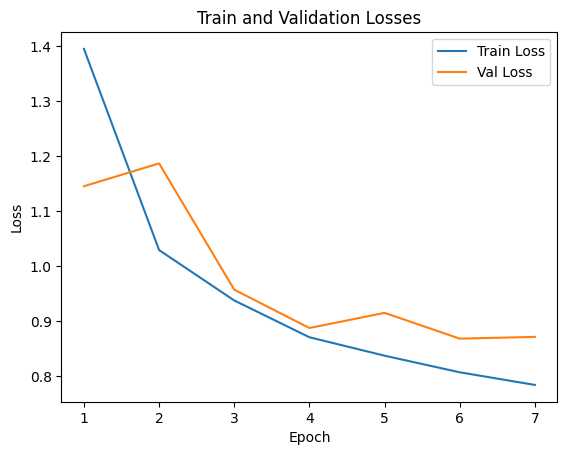

In [ ]:
os.makedirs("checkpoints", exist_ok=True)

loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

def run_training():
    model_path = "checkpoints/best_model.pt"

    model = CellTypeClassifier(n_genes=len(gene_ids), n_bins=N_BINS, d_model=128, n_classes=len(label_encoder.classes_), n_layers=4)

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_model(model=model, model_path=model_path, optimizer=optimizer, loss_fn=loss_fn)
    return model


model = run_training()

### Evaluation

In [ ]:
# Show the classification metrics report
conf_mat_dl = evaluate_test(model, test_loader, loss_fn)

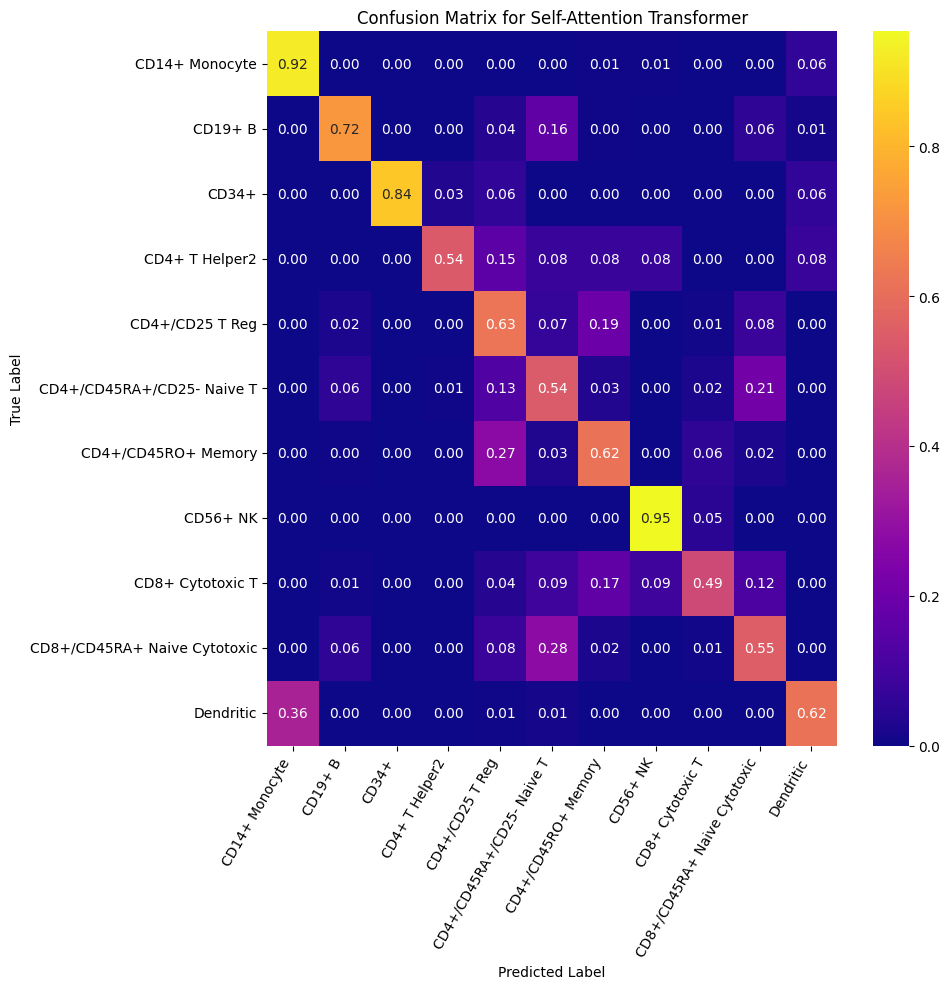

In [ ]:
# @title
# Plot the confusion matrix
conf_mat_pd_dl = pd.DataFrame(conf_mat_dl, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 10))  # Adjust size as needed
sns.heatmap(conf_mat_pd_dl, annot=True, fmt=".2f", cmap="plasma", cbar=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Self-Attention Transformer")
plt.xticks(rotation=60, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# @title
with torch.no_grad():
    torch.cuda.empty_cache()

# Logistic Regression compared to Self-Attention Transformer

The cell below plots the confusion matrices of the Self-Attention Transfomer and the Logistic Regression models side by side for comparison.

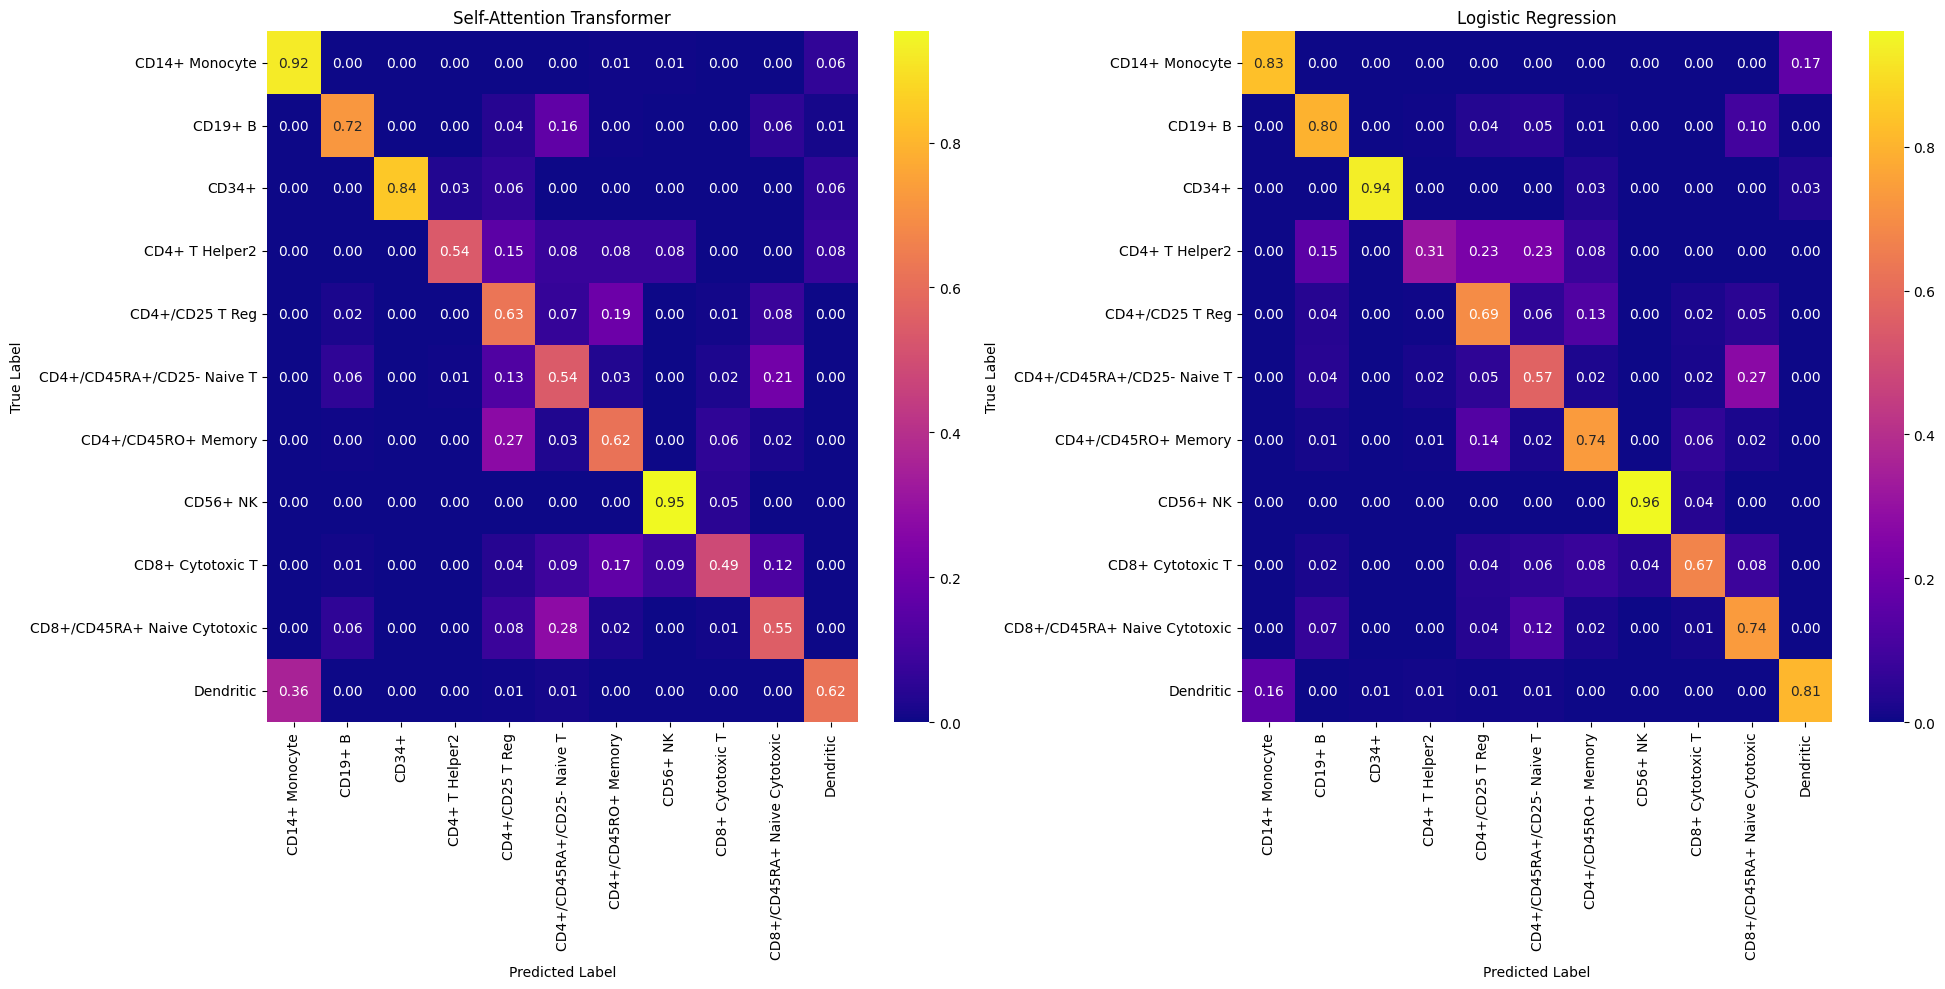

In [ ]:
# @title
# Plot the Transformer and the Logistic regression confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

sns.heatmap(conf_mat_pd_dl, annot=True, fmt=".2f", cmap="plasma", cbar=True,
            ax=axes[0])
axes[0].set_title("Self-Attention Transformer")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].tick_params(axis='x', rotation=90)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(conf_mat_pd_lr, annot=True, fmt=".2f", cmap="plasma", cbar=True,
            ax=axes[1])
axes[1].set_title("Logistic Regression")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Next steps
- Explore clustering for better data splitting to reduce overfitting.

Try more ideas from scGPT:
- Try *cls* token to learn cell representation.
- Change to generative task and fine-tune for classification.
- Experiment with different hyper-parameter values for the number of expression intervals and other hyper-parameters
